
[INFO] Memproses education_index and healthcare_index tahun 2000.png...
    -> Peringatan OCR Judul: tesseract is not installed or it's not in your PATH. See README file for more information.
  -> Mengekstrak 'education_index'...
  -> Mengekstrak 'healthcare_index'...

[INFO] Memproses education_index and healthcare_index tahun 2001.png...
    -> Peringatan OCR Judul: tesseract is not installed or it's not in your PATH. See README file for more information.
  -> Mengekstrak 'education_index'...
  -> Mengekstrak 'healthcare_index'...

[INFO] Memproses education_index and healthcare_index tahun 2002.png...
    -> Peringatan OCR Judul: tesseract is not installed or it's not in your PATH. See README file for more information.
  -> Mengekstrak 'education_index'...
  -> Mengekstrak 'healthcare_index'...

[INFO] Memproses education_index and healthcare_index tahun 2003.png...
    -> Peringatan OCR Judul: tesseract is not installed or it's not in your PATH. See README file for more informatio

C:\Users\LENOVO\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


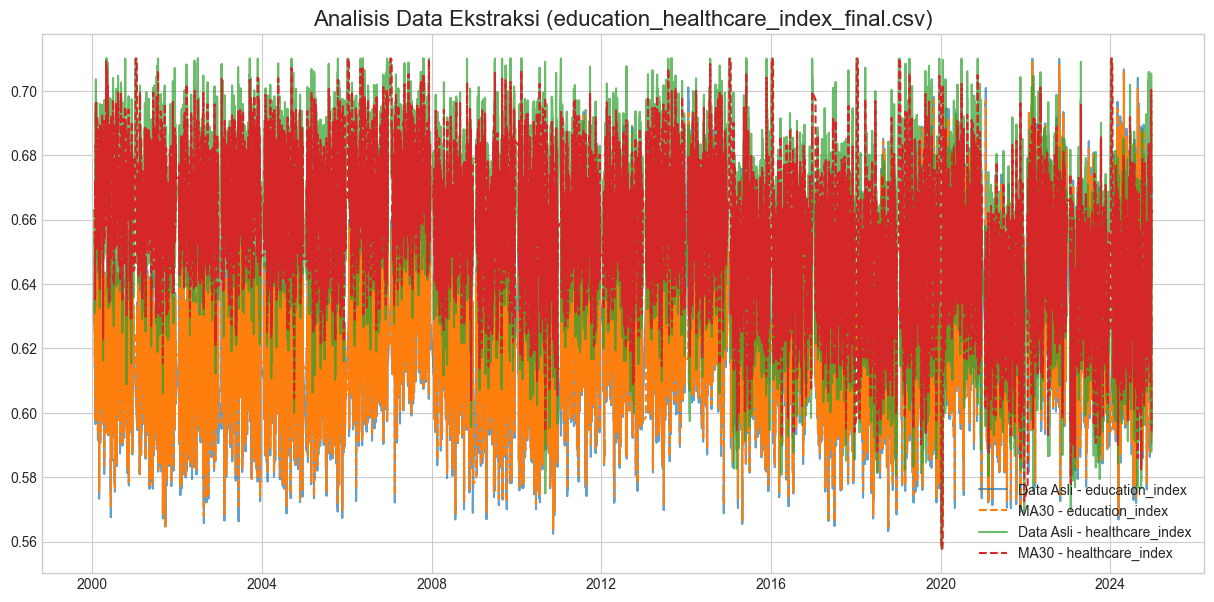


✅ SUKSES! 794789 baris data disimpan ke education_healthcare_index_final.csv


In [2]:
# ==============================================================================
# Script Ekstraksi Data Grafik v3.1 (Multi-Variabel Profesional)
# Deskripsi:
#   Mengekstrak data dari gambar grafik yang berisi satu atau lebih garis data.
#   Struktur modular untuk kemudahan konfigurasi dan pemeliharaan.
#
# Kebutuhan: opencv-python, numpy, pandas, pytesseract, matplotlib
# ==============================================================================
import cv2
import numpy as np
import pandas as pd
import re
import os
import matplotlib.pyplot as plt
import pytesseract
from typing import List, Dict, Tuple, Optional, Any
from datetime import datetime, timedelta

# (Letakkan blok CONFIG dari atas di sini)
CONFIG = {
    "folder_path": r"C:\Users\LENOVO\Downloads\statexplore\Data\C01\education_index and healthcare_index",
    "output_csv_file": "education_healthcare_index_final.csv",
    "years_to_process": [],
    "fallback_y_min": 0.55,
    "fallback_y_max": 0.72,
    "clamp_y_min": 0.54,
    "clamp_y_max": 0.71,
    "variables": [
        {"name": "education_index", "lower_color": np.array([90, 80, 50]), "upper_color": np.array([130, 255, 255])},
        {"name": "healthcare_index", "lower_color": np.array([10, 80, 80]), "upper_color": np.array([25, 255, 255])}
    ],
    "debug_mode": False,
    "visualize_output": True
}
# ==============================================================================
# 2. FUNGSI-FUNGSI BANTU (Utility Functions)
# ==============================================================================
def is_leap(year: int) -> bool:
    """Mengecek apakah suatu tahun adalah tahun kabisat."""
    return year % 4 == 0 and (year % 100 != 0 or year % 400 == 0)

def clean_mask(mask: np.ndarray) -> np.ndarray:
    """Menggunakan morphological opening untuk menghapus noise dari mask."""
    kernel = np.ones((3, 3), np.uint8)
    return cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)

# ==============================================================================
# 3. FUNGSI EKSTRAKSI INTI (Core Extraction Functions)
# ==============================================================================
def extract_year_from_title(title_crop: np.ndarray) -> Optional[int]:
    """Mengekstrak tahun dari potongan gambar judul menggunakan OCR."""
    try:
        title_text = pytesseract.image_to_string(title_crop, config="--psm 6")
        match = re.search(r'\b(20\d{2})\b', title_text)
        if match: return int(match.group(1))
    except Exception as e:
        print(f"    -> Peringatan OCR Judul: {e}")
    return None

def extract_series_from_mask(mask: np.ndarray, params: Dict[str, Any]) -> pd.DataFrame:
    """
    Mengekstrak data deret waktu dari sebuah mask warna.
    
    Args:
        mask (np.ndarray): Mask biner (hitam-putih) dari garis data.
        params (Dict): Dictionary berisi parameter seperti tahun, rentang y, dll.
        
    Returns:
        pd.DataFrame: DataFrame berisi data yang diekstrak.
    """
    extracted_data = []
    plot_h, plot_w = mask.shape
    days_in_year = 366 if is_leap(params['year']) else 365
    start_date = datetime(params['year'], 1, 1)
    
    for x_pixel in range(plot_w):
        y_pixels = np.where(mask[:, x_pixel] > 0)[0]
        if len(y_pixels) > 0:
            y_pixel_center = int(np.median(y_pixels))
            value = params['y_max'] - ((y_pixel_center / plot_h) * (params['y_max'] - params['y_min']))
            value = max(min(value, params['clamp_y_max']), params['clamp_y_min'])
            day_of_year = int((x_pixel / plot_w) * days_in_year)
            date = start_date + timedelta(days=day_of_year)
            
            # Perbaikan Bug: Menggunakan params['var_name'] sebagai kunci dictionary
            extracted_data.append({
                "Date": date.strftime("%Y-%m-%d"),
                "Year": params['year'],
                "DayOfYear": day_of_year + 1,
                params['var_name']: round(value, 4)
            })
    return pd.DataFrame(extracted_data)

def process_single_image(image_path: str, config: Dict[str, Any]) -> Optional[pd.DataFrame]:
    """Memproses satu file gambar dan mengembalikan hasilnya sebagai DataFrame."""
    filename = os.path.basename(image_path)
    print(f"\n[INFO] Memproses {filename}...")
    img = cv2.imread(image_path)
    if img is None:
        print(f"  -> [Gagal] Tidak dapat membaca file gambar.")
        return None

    h, w, _ = img.shape
    title_crop = img[0:int(h*0.1), 0:w]
    plot_area = img[int(h*0.12):int(h*0.9), int(w*0.05):int(w*0.98)]
    
    year_ocr = extract_year_from_title(title_crop)
    year_from_file = int(re.search(r'(\d{4})', filename).group(1))
    year = year_ocr if year_ocr else year_from_file
    y_min, y_max = config['fallback_y_min'], config['fallback_y_max']

    hsv = cv2.cvtColor(plot_area, cv2.COLOR_BGR2HSV)
    
    variables_to_process = config.get('variables', [{"name": config.get('var_name'), "lower_color": config.get('lower_color'), "upper_color": config.get('upper_color')}])

    all_vars_df = []
    for var_info in variables_to_process:
        var_name = var_info['name']
        print(f"  -> Mengekstrak '{var_name}'...")
        mask = cv2.inRange(hsv, var_info['lower_color'], var_info['upper_color'])
        cleaned_mask = clean_mask(mask)
        series_params = {
            'year': year, 'y_min': y_min, 'y_max': y_max,
            'clamp_y_min': config['clamp_y_min'], 'clamp_y_max': config['clamp_y_max'],
            'var_name': var_name
        }
        df_var = extract_series_from_mask(cleaned_mask, series_params)
        if not df_var.empty:
            all_vars_df.append(df_var)

    if not all_vars_df: return None
    
    final_df = all_vars_df[0]
    for i in range(1, len(all_vars_df)):
        final_df = pd.merge(final_df, all_vars_df[i], on=["Date", "Year", "DayOfYear"], how="outer")
        
    return final_df.sort_values(by="Date")

# ==============================================================================
# 4. FUNGSI PASCA-PROSES & VISUALISASI
# ==============================================================================
def post_process_data(df: pd.DataFrame, config: Dict[str, Any]) -> pd.DataFrame:
    """Membersihkan, mengubah, dan menambah fitur pada data gabungan."""
    proc_df = df.copy()
    proc_df['Date'] = pd.to_datetime(proc_df['Date'])
    proc_df = proc_df.sort_values(by='Date').set_index('Date').drop(columns=['Year', 'DayOfYear'])
    proc_df.interpolate(method='time', inplace=True)
    proc_df.dropna(inplace=True)
    
    vars_to_analyze = [v['name'] for v in config.get('variables', [])] or [config.get('var_name')]
    for var_name in vars_to_analyze:
        if var_name in proc_df.columns:
            proc_df[f'{var_name}_MA30'] = proc_df[var_name].rolling(window=30).mean()
    return proc_df

def visualize_results(df: pd.DataFrame, config: Dict[str, Any]):
    """Membuat plot visual dari data akhir."""
    title = f"Analisis Data Ekstraksi ({config['output_csv_file']})"
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(15, 7))
    
    vars_to_plot = [v['name'] for v in config.get('variables', [])] or [config.get('var_name')]
    for var_name in vars_to_plot:
        if var_name in df.columns:
            ax.plot(df.index, df[var_name], label=f'Data Asli - {var_name}', alpha=0.7)
            ax.plot(df.index, df[f'{var_name}_MA30'], label=f'MA30 - {var_name}', linestyle='--')
    ax.set_title(title, fontsize=16)
    ax.legend()
    plt.show()

# ==============================================================================
# 5. FUNGSI UTAMA (Runner)
# ==============================================================================
def main(config: Dict[str, Any]):
    """Fungsi utama untuk menjalankan seluruh alur kerja."""
    if not os.path.isdir(config['folder_path']):
        print(f"❌ KESALAHAN: Folder tidak ditemukan di '{config['folder_path']}'.")
        return

    all_files = sorted([f for f in os.listdir(config['folder_path']) if f.endswith(".png")])
    files_to_process = all_files # Tambahkan logika filter tahun jika perlu
    
    results_list = [process_single_image(os.path.join(config['folder_path'], f), config) for f in files_to_process]
    
    valid_results = [df for df in results_list if df is not None and not df.empty]
    if not valid_results:
        print("\n⚠️ PROSES SELESAI: Tidak ada data yang berhasil diekstrak.")
        return

    raw_df = pd.concat(valid_results, ignore_index=True)
    analyzed_df = post_process_data(raw_df, config)
    if config.get('visualize_output', False):
        visualize_results(analyzed_df, config)
    
    analyzed_df.reset_index(inplace=True)
    analyzed_df.to_csv(config['output_csv_file'], index=False)
    print(f"\n✅ SUKSES! {len(analyzed_df)} baris data disimpan ke {config['output_csv_file']}")

if __name__ == '__main__':
    main(CONFIG)


[INFO] Memproses education_index and healthcare_index tahun 2000.png...
  -> Mengekstrak 'education_index'...
  -> Mengekstrak 'healthcare_index'...

[INFO] Memproses education_index and healthcare_index tahun 2001.png...
  -> Mengekstrak 'education_index'...
  -> Mengekstrak 'healthcare_index'...

[INFO] Memproses education_index and healthcare_index tahun 2002.png...
  -> Mengekstrak 'education_index'...
  -> Mengekstrak 'healthcare_index'...

[INFO] Memproses education_index and healthcare_index tahun 2003.png...
  -> Mengekstrak 'education_index'...
  -> Mengekstrak 'healthcare_index'...

[INFO] Memproses education_index and healthcare_index tahun 2004.png...
  -> Mengekstrak 'education_index'...
  -> Mengekstrak 'healthcare_index'...

[INFO] Memproses education_index and healthcare_index tahun 2005.png...
  -> Mengekstrak 'education_index'...
  -> Mengekstrak 'healthcare_index'...

[INFO] Memproses education_index and healthcare_index tahun 2006.png...
  -> Mengekstrak 'education

C:\Users\LENOVO\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


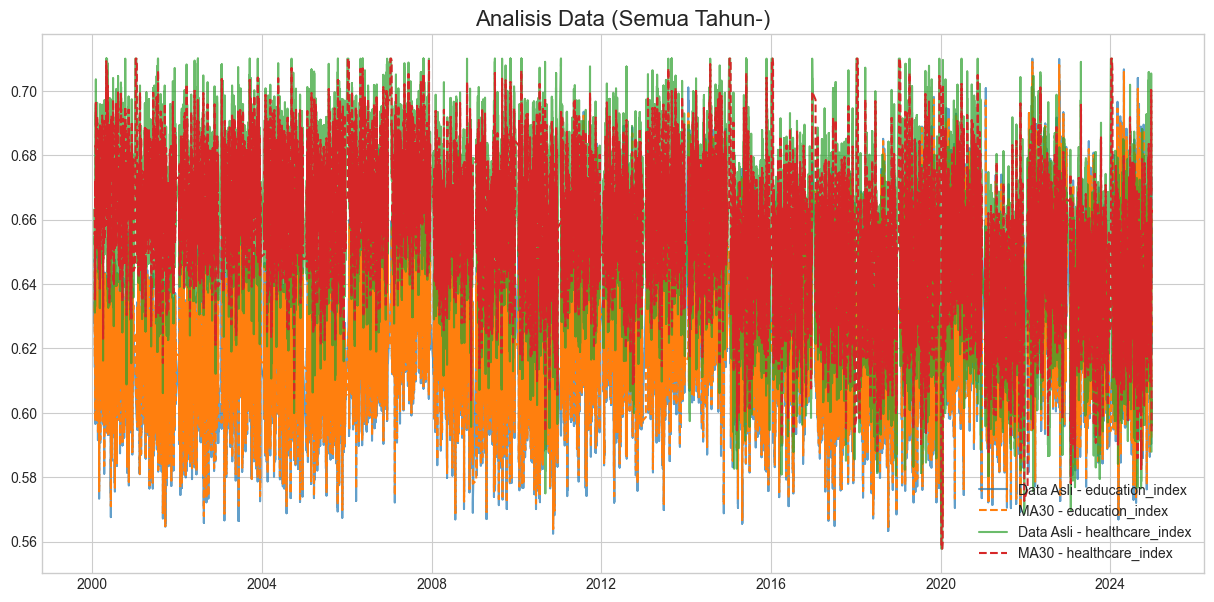


✅ SUKSES! 794789 baris data disimpan ke education_healthcare_extracted.csv



[INFO] Memproses energy_consumption_mwh tahun 2000.png...
  -> Mengekstrak 'energy_consumption_mwh'...

[INFO] Memproses energy_consumption_mwh tahun 2001.png...
  -> Mengekstrak 'energy_consumption_mwh'...

[INFO] Memproses energy_consumption_mwh tahun 2002.png...
  -> Mengekstrak 'energy_consumption_mwh'...

[INFO] Memproses energy_consumption_mwh tahun 2003.png...
  -> Mengekstrak 'energy_consumption_mwh'...

[INFO] Memproses energy_consumption_mwh tahun 2004.png...
  -> Mengekstrak 'energy_consumption_mwh'...

[INFO] Memproses energy_consumption_mwh tahun 2005.png...
  -> Mengekstrak 'energy_consumption_mwh'...

[INFO] Memproses energy_consumption_mwh tahun 2006.png...
  -> Mengekstrak 'energy_consumption_mwh'...

[INFO] Memproses energy_consumption_mwh tahun 2007.png...
  -> Mengekstrak 'energy_consumption_mwh'...

[INFO] Memproses energy_consumption_mwh tahun 2008.png...
  -> Mengekstrak 'energy_consumption_mwh'...

[INFO] Memproses energy_consumption_mwh tahun 2009.png...
  -> 

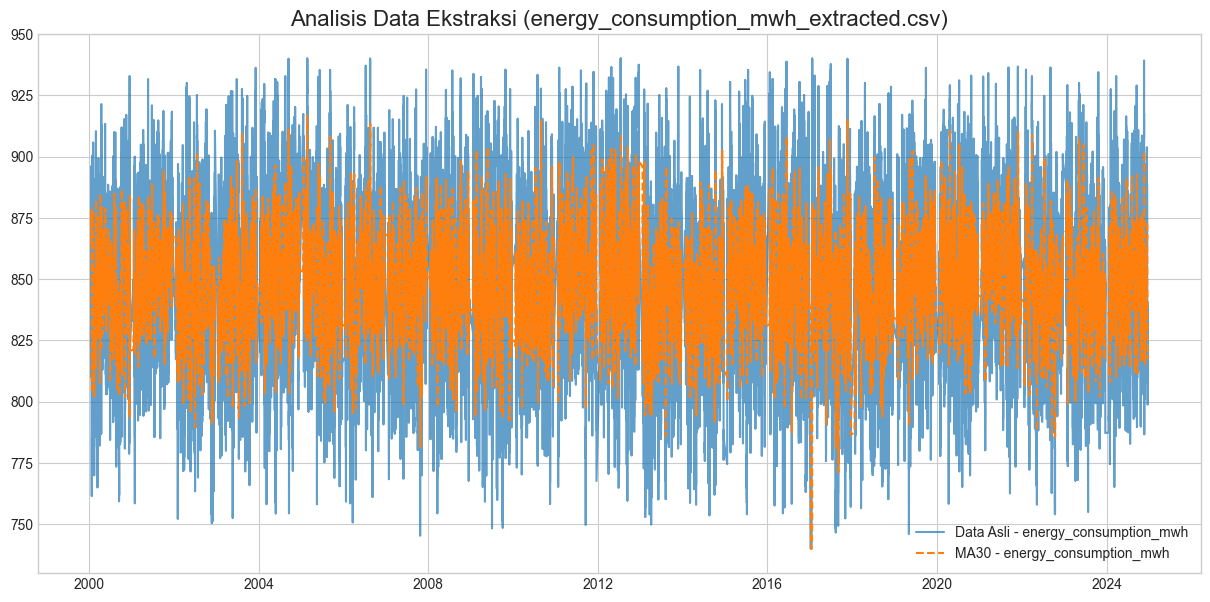


✅ SUKSES! 84791 baris data disimpan ke energy_consumption_mwh_extracted.csv


In [3]:
# ==============================================================================
# Script Ekstraksi Data Grafik v3.2 (Fleksibel Multi/Single Variabel)
# Deskripsi:
#   Mengekstrak data dari gambar grafik. Otomatis menangani data dengan
#   satu atau banyak variabel berdasarkan pengaturan di CONFIG.
#
# Kebutuhan: opencv-python, numpy, pandas, pytesseract, matplotlib
# ==============================================================================

import cv2
import numpy as np
import pandas as pd
import re
import os
import matplotlib.pyplot as plt
import pytesseract
from typing import List, Dict, Tuple, Optional, Any
from datetime import datetime, timedelta

# (Letakkan blok CONFIG dari atas di sini)
CONFIG = {
    "folder_path": r"C:\Users\LENOVO\Downloads\statexplore\Data\C01\energy_consumption_mwh",
    "output_csv_file": "energy_consumption_mwh_extracted.csv",
    "years_to_process": [],
    "fallback_y_min": 725,
    "fallback_y_max": 950,
    "clamp_y_min": 740,
    "clamp_y_max": 940,
    "var_name": "energy_consumption_mwh",
    "lower_color": np.array([90, 80, 50]),
    "upper_color": np.array([130, 255, 255]),
    "debug_mode": False,
    "visualize_output": True
}

# ==============================================================================
# 2. FUNGSI-FUNGSI BANTU (Utility Functions)
# ==============================================================================
def is_leap(year: int) -> bool:
    """Mengecek apakah suatu tahun adalah tahun kabisat."""
    return year % 4 == 0 and (year % 100 != 0 or year % 400 == 0)

def clean_mask(mask: np.ndarray) -> np.ndarray:
    """Menggunakan morphological opening untuk menghapus noise dari mask."""
    kernel = np.ones((3, 3), np.uint8)
    return cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)

# ==============================================================================
# 3. FUNGSI EKSTRAKSI INTI (Core Extraction Functions)
# ==============================================================================
def extract_year_from_title(title_crop: np.ndarray) -> Optional[int]:
    """Mengekstrak tahun dari potongan gambar judul menggunakan OCR."""
    try:
        title_text = pytesseract.image_to_string(title_crop, config="--psm 6")
        match = re.search(r'\b(20\d{2})\b', title_text)
        if match: return int(match.group(1))
    except Exception as e:
        # Menampilkan error hanya jika mode debug aktif untuk menjaga output tetap bersih
        if CONFIG.get("debug_mode"):
            print(f"    -> Peringatan OCR Judul: {e}")
    return None

def extract_series_from_mask(mask: np.ndarray, params: Dict[str, Any]) -> pd.DataFrame:
    """Mengekstrak data deret waktu dari sebuah mask warna."""
    extracted_data = []
    plot_h, plot_w = mask.shape
    days_in_year = 366 if is_leap(params['year']) else 365
    start_date = datetime(params['year'], 1, 1)
    
    for x_pixel in range(plot_w):
        y_pixels = np.where(mask[:, x_pixel] > 0)[0]
        if len(y_pixels) > 0:
            y_pixel_center = int(np.median(y_pixels))
            value = params['y_max'] - ((y_pixel_center / plot_h) * (params['y_max'] - params['y_min']))
            value = max(min(value, params['clamp_y_max']), params['clamp_y_min'])
            day_of_year = int((x_pixel / plot_w) * days_in_year)
            date = start_date + timedelta(days=day_of_year)
            
            extracted_data.append({
                "Date": date.strftime("%Y-%m-%d"),
                "Year": params['year'],
                "DayOfYear": day_of_year + 1,
                params['var_name']: round(value, 2) # Presisi 2 desimal cukup
            })
    return pd.DataFrame(extracted_data)

def process_single_image(image_path: str, config: Dict[str, Any]) -> Optional[pd.DataFrame]:
    """Memproses satu file gambar dan mengembalikan hasilnya sebagai DataFrame."""
    filename = os.path.basename(image_path)
    print(f"\n[INFO] Memproses {filename}...")
    img = cv2.imread(image_path)
    if img is None:
        print(f"  -> [Gagal] Tidak dapat membaca file gambar.")
        return None

    h, w, _ = img.shape
    title_crop = img[0:int(h*0.1), 0:w]
    plot_area = img[int(h*0.12):int(h*0.9), int(w*0.05):int(w*0.98)]
    
    year_ocr = extract_year_from_title(title_crop)
    year_from_file = int(re.search(r'(\d{4})', filename).group(1))
    year = year_ocr if year_ocr else year_from_file
    y_min, y_max = config['fallback_y_min'], config['fallback_y_max']

    hsv = cv2.cvtColor(plot_area, cv2.COLOR_BGR2HSV)
    
    # Logika fleksibel untuk menangani satu atau banyak variabel dari CONFIG
    variables_to_process = config.get('variables', [{"name": config.get('var_name'), "lower_color": config.get('lower_color'), "upper_color": config.get('upper_color')}])

    all_vars_df = []
    for var_info in variables_to_process:
        var_name = var_info['name']
        print(f"  -> Mengekstrak '{var_name}'...")
        mask = cv2.inRange(hsv, var_info['lower_color'], var_info['upper_color'])
        cleaned_mask = clean_mask(mask)
        series_params = {
            'year': year, 'y_min': y_min, 'y_max': y_max,
            'clamp_y_min': config['clamp_y_min'], 'clamp_y_max': config['clamp_y_max'],
            'var_name': var_name
        }
        df_var = extract_series_from_mask(cleaned_mask, series_params)
        if not df_var.empty:
            all_vars_df.append(df_var)

    if not all_vars_df: return None
    
    # Menggabungkan DataFrame jika ada lebih dari satu variabel
    final_df = all_vars_df[0]
    for i in range(1, len(all_vars_df)):
        final_df = pd.merge(final_df, all_vars_df[i], on=["Date", "Year", "DayOfYear"], how="outer")
        
    return final_df.sort_values(by="Date")

# ==============================================================================
# 4. FUNGSI PASCA-PROSES & VISUALISASI
# ==============================================================================
def post_process_data(df: pd.DataFrame, config: Dict[str, Any]) -> pd.DataFrame:
    """Membersihkan, mengubah, dan menambah fitur pada data gabungan."""
    proc_df = df.copy()
    proc_df['Date'] = pd.to_datetime(proc_df['Date'])
    proc_df = proc_df.sort_values(by='Date').set_index('Date').drop(columns=['Year', 'DayOfYear'])
    proc_df.interpolate(method='time', inplace=True)
    proc_df.dropna(inplace=True)
    
    vars_to_analyze = [v['name'] for v in config.get('variables', [])] or [config.get('var_name')]
    for var_name in vars_to_analyze:
        if var_name in proc_df.columns:
            proc_df[f'{var_name}_MA30'] = proc_df[var_name].rolling(window=30).mean()
    return proc_df

def visualize_results(df: pd.DataFrame, config: Dict[str, Any]):
    """Membuat plot visual dari data akhir."""
    title = f"Analisis Data Ekstraksi ({config['output_csv_file']})"
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(15, 7))
    
    vars_to_plot = [v['name'] for v in config.get('variables', [])] or [config.get('var_name')]
    for var_name in vars_to_plot:
        if var_name in df.columns:
            ax.plot(df.index, df[var_name], label=f'Data Asli - {var_name}', alpha=0.7)
            ax.plot(df.index, df[f'{var_name}_MA30'], label=f'MA30 - {var_name}', linestyle='--')
    ax.set_title(title, fontsize=16)
    ax.legend()
    plt.show()

# ==============================================================================
# 5. FUNGSI UTAMA (Runner)
# ==============================================================================
def main(config: Dict[str, Any]):
    """Fungsi utama untuk menjalankan seluruh alur kerja."""
    # Aktifkan path Tesseract jika disetel di CONFIG
    tesseract_cmd = config.get("tesseract_cmd")
    if tesseract_cmd and os.path.exists(tesseract_cmd):
        pytesseract.pytesseract.tesseract_cmd = tesseract_cmd

    if not os.path.isdir(config['folder_path']):
        print(f"❌ KESALAHAN: Folder tidak ditemukan di '{config['folder_path']}'.")
        return

    all_files = sorted([f for f in os.listdir(config['folder_path']) if f.endswith(".png")])
    # Di sini bisa ditambahkan logika filter tahun dari config['years_to_process'] jika diperlukan
    
    results_list = [process_single_image(os.path.join(config['folder_path'], f), config) for f in all_files]
    
    valid_results = [df for df in results_list if df is not None and not df.empty]
    if not valid_results:
        print("\n⚠️ PROSES SELESAI: Tidak ada data yang berhasil diekstrak.")
        return

    raw_df = pd.concat(valid_results, ignore_index=True)
    analyzed_df = post_process_data(raw_df, config)
    if config.get('visualize_output', True):
        visualize_results(analyzed_df, config)
    
    analyzed_df.reset_index(inplace=True)
    analyzed_df.to_csv(config['output_csv_file'], index=False)
    print(f"\n✅ SUKSES! {len(analyzed_df)} baris data disimpan ke {config['output_csv_file']}")

# ==============================================================================
# 6. TITIK MASUK PROGRAM
# ==============================================================================
if __name__ == '__main__':
    main(CONFIG)